In [6]:
%matplotlib notebook
import control as c
import ipywidgets as w
import numpy as np

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

display(HTML('<script> $(document).ready(function() { $("div.input").hide(); }); </script>'))

Traceback (most recent call last):
  File "C:\Users\Uporabnik\Anaconda3\envs\icct2\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\Uporabnik\Anaconda3\envs\icct2\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


## PID control of a First-Order system with Integrator

In the following example, we will be using a PID controller (or one of its subtypes) to control a first-order LTI (linear time-invariant system) with an attached integrator.

The system consists of a single stable pole multiplied with the transfer function of the integrator, both of which can be expressed using time constants:
<br><br>
$$G(s)=\frac{1}{T_{1}T_{int}s^2 + T_{int}s}$$
<br>
A typical example of a first-order system with an integrator is a mass-damper system with force input and position output:
<br>
<img src="Images/first_order_integrating.png" width="30%" />
<br>
Where the transfer function can be expressed as:
<br>
$$G(s) = \frac{X(s)}{F(s)} = \frac{1}{ms^2+bs} \qquad T_{1}=\frac{m}{b} \qquad T_{int}=b$$
<br>
<b>Choose time constants for the system!</b>

<IPython.core.display.Javascript object>


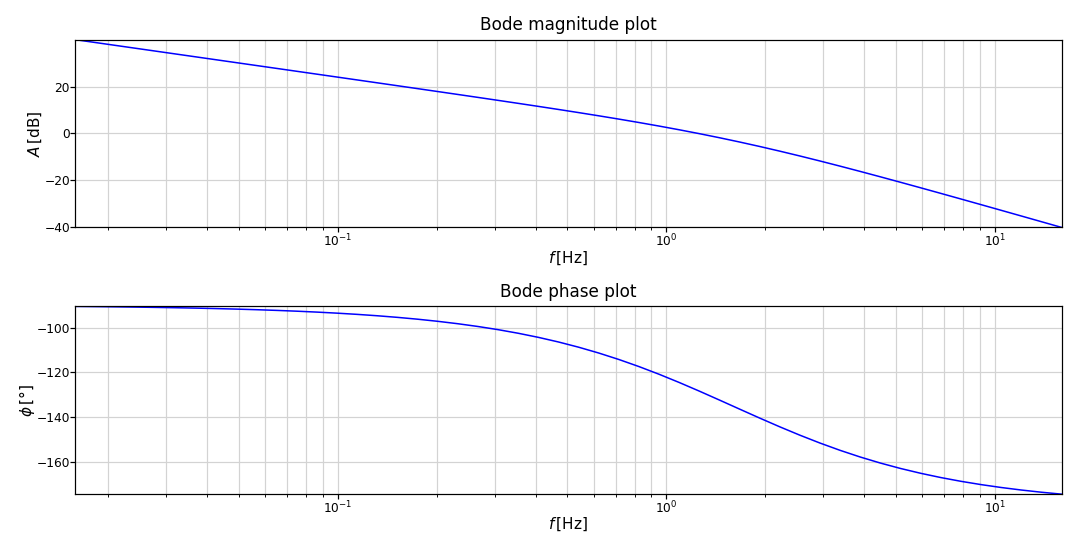

Output()

In [7]:
# Figure definition

fig1, ((f1_ax1), (f1_ax2)) = plt.subplots(2, 1)
fig1.set_size_inches((9.8, 5))
fig1.set_tight_layout(True)

f1_line1, = f1_ax1.plot([], [])
f1_line2, = f1_ax2.plot([], [])  

f1_ax1.grid(which='both', axis='both', color='lightgray')
f1_ax2.grid(which='both', axis='both', color='lightgray')

f1_ax1.autoscale(enable=True, axis='both', tight=True)
f1_ax2.autoscale(enable=True, axis='both', tight=True)

f1_ax1.set_title('Bode magnitude plot', fontsize=11)
f1_ax1.set_xscale('log')
f1_ax1.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax1.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=10)
f1_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

f1_ax2.set_title('Bode phase plot', fontsize=11)
f1_ax2.set_xscale('log')
f1_ax2.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=10)
f1_ax2.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=10)
f1_ax2.tick_params(axis='both', which='both', pad=0, labelsize=8)   


# System model

def system_model(T1, Tint):

    W_sys = c.tf([1], [T1*Tint, Tint, 0])

    print('System transfer function:')
    print(W_sys)

    # System analysis

    poles = c.pole(W_sys)     # Poles

    print('System poles:\n')
    print(poles)
    
    global f1_line1, f1_line2
    
    f1_ax1.lines.remove(f1_line1)
    f1_ax2.lines.remove(f1_line2)

    mag, phase, omega = c.bode_plot(W_sys, Plot=False)   # Bode-plot

    f1_line1, = f1_ax1.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f1_line2, = f1_ax2.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')   

    f1_ax1.relim()
    f1_ax2.relim()
    f1_ax1.autoscale_view()
    f1_ax2.autoscale_view()
    
# GUI widgets
    
T1_slider = w.FloatLogSlider(value=0.1, base=10, min=-4, max=1, description='T1 [s] :', continuous_update=False,
                             layout=w.Layout(width='75%'))
Tint_slider = w.FloatLogSlider(value=0.1, base=10, min=-4, max=1, description='Tint [s] :', continuous_update=False,
                             layout=w.Layout(width='75%'))

input_data = w.interactive_output(system_model, {'T1':T1_slider, 'Tint':Tint_slider})

display(w.HBox([T1_slider, Tint_slider]), input_data)

After observing the system's characteristics, <b>select a controller type!</b>

In [8]:
#Controller type select

typeSelect = w.ToggleButtons(
    options=[('P', 0), ('PI', 1), ('PD', 2), ('PID', 3), ('PID Realistic', 4)],
    description='Controller type: ', style={'description_width':'15%'})

display(typeSelect)

ToggleButtons(description='Controller type: ', options=(('P', 0), ('PI', 1), ('PD', 2), ('PID', 3), ('PID Real…

<b>Tune the selected controller so that rising/settling time, overshoot, or remaining error is minimized!</b><br>
It is not possible to get the best results for each parameter in a single setup. Create multiple solutions, one for each type!

<IPython.core.display.Javascript object>


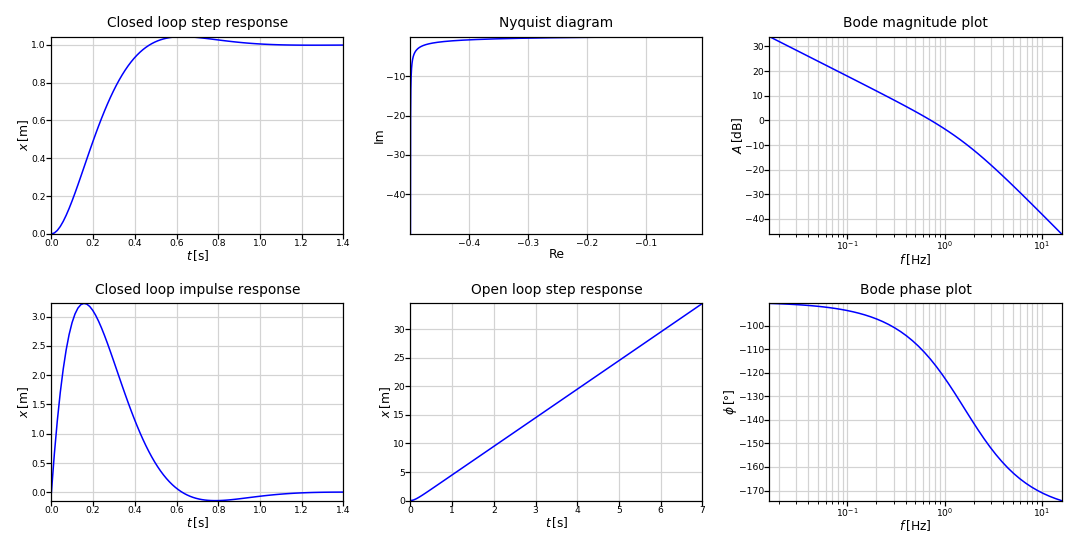

Output()

In [9]:
# PID control

# Figure definition
fig2, ((f2_ax1, f2_ax2, f2_ax3), (f2_ax4, f2_ax5, f2_ax6)) = plt.subplots(2, 3)
fig2.set_size_inches((9.8, 5))
fig2.set_tight_layout(True)

f2_line1, = f2_ax1.plot([], [])
f2_line2, = f2_ax2.plot([], []) 
f2_line3, = f2_ax3.plot([], [])
f2_line4, = f2_ax4.plot([], [])  
f2_line5, = f2_ax5.plot([], [])
f2_line6, = f2_ax6.plot([], [])

f2_ax1.grid(which='both', axis='both', color='lightgray')
f2_ax2.grid(which='both', axis='both', color='lightgray')
f2_ax3.grid(which='both', axis='both', color='lightgray')
f2_ax4.grid(which='both', axis='both', color='lightgray')
f2_ax5.grid(which='both', axis='both', color='lightgray')
f2_ax6.grid(which='both', axis='both', color='lightgray')

f2_ax1.autoscale(enable=True, axis='both', tight=True)
f2_ax2.autoscale(enable=True, axis='both', tight=True)
f2_ax3.autoscale(enable=True, axis='both', tight=True)
f2_ax4.autoscale(enable=True, axis='both', tight=True)
f2_ax5.autoscale(enable=True, axis='both', tight=True)
f2_ax6.autoscale(enable=True, axis='both', tight=True)

f2_ax1.set_title('Closed loop step response', fontsize=9)
f2_ax1.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax1.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax1.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax2.set_title('Nyquist diagram', fontsize=9)
f2_ax2.set_xlabel(r'Re', labelpad=0, fontsize=8)
f2_ax2.set_ylabel(r'Im', labelpad=0, fontsize=8)
f2_ax2.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax3.set_title('Bode magnitude plot', fontsize=9)
f2_ax3.set_xscale('log')
f2_ax3.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=8)
f2_ax3.set_ylabel(r'$A\/$[dB]', labelpad=0, fontsize=8)
f2_ax3.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax4.set_title('Closed loop impulse response', fontsize=9)
f2_ax4.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax4.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax4.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax5.set_title('Open loop step response', fontsize=9)
f2_ax5.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=8)
f2_ax5.set_ylabel(r'$x\/$[m]', labelpad=0, fontsize=8)
f2_ax5.tick_params(axis='both', which='both', pad=0, labelsize=6)

f2_ax6.set_title('Bode phase plot', fontsize=9)
f2_ax6.set_xscale('log')
f2_ax6.set_xlabel(r'$f\/$[Hz]', labelpad=0, fontsize=8)
f2_ax6.set_ylabel(r'$\phi\/$[°]', labelpad=0, fontsize=8)
f2_ax6.tick_params(axis='both', which='both', pad=0, labelsize=6)

def pid_control(Kp, Ti, Td, Fd, type_select, T1, Tint):
    
    W_sys = c.tf([1], [T1*Tint, Tint, 0])
    
    if type_select in (1, 3, 4):
        Ti0 = 1
    else:
        Ti0 = 0
        
    if type_select in (2, 3, 4):
        Td0 = 1
    else :
        Td0 = 0
        
    if type_select == 4:
        Fd0 = 1
    else:
        Fd0 = 0
    
    # PID Controller
    
    P = Kp             # Proportional term
    I = Kp / Ti        # Integral term
    D = Kp * Td        # Derivative term
    Td_f = Td / Fd     # Derivative term filter
    
    W_PID = c.parallel(c.tf([P], [1]),
                       c.tf([I * Ti0], [1 * Ti0, 1 * (not Ti0)]),
                       c.tf([D * Td0, 0], [Td_f * Td0 * Fd0, 1]))  # PID controller in time constant format
    
    W_open = c.series(W_PID, W_sys)         # Open loop
    W_closed = c.feedback(W_open, 1, -1)    # Closed loop with negative feedback
                        
    # Display
                        
    global f2_line1, f2_line2, f2_line3, f2_line4, f2_line5, f2_line6
    
    f2_ax1.lines.remove(f2_line1)
    f2_ax2.lines.remove(f2_line2)
    f2_ax3.lines.remove(f2_line3)
    f2_ax4.lines.remove(f2_line4)
    f2_ax5.lines.remove(f2_line5)
    f2_ax6.lines.remove(f2_line6)
    
    tout, yout = c.step_response(W_closed)
    f2_line1, = f2_ax1.plot(tout, yout, lw=1, color='blue') 

    _, _, ob = c.nyquist_plot(W_open, Plot=False)   # Small resolution plot to determine bounds        
    real, imag, freq = c.nyquist_plot(W_open, omega=np.logspace(np.log10(ob[0]), np.log10(ob[-1]), 1000), Plot=False)
    f2_line2, = f2_ax2.plot(real, imag, lw=1, color='blue')
    
    mag, phase, omega = c.bode_plot(W_open, Plot=False)
    f2_line3, = f2_ax3.plot(omega/2/np.pi, 20*np.log10(mag), lw=1, color='blue')
    f2_line6, = f2_ax6.plot(omega/2/np.pi, phase*180/np.pi, lw=1, color='blue')

    tout, yout = c.impulse_response(W_closed)
    f2_line4, = f2_ax4.plot(tout, yout, lw=1, color='blue')   
    
    tout, yout = c.step_response(W_open)
    f2_line5, = f2_ax5.plot(tout, yout, lw=1, color='blue') 
    
    f2_ax1.relim()
    f2_ax2.relim()
    f2_ax3.relim()
    f2_ax4.relim()
    f2_ax5.relim()
    f2_ax6.relim()
    f2_ax1.autoscale_view()
    f2_ax2.autoscale_view()
    f2_ax3.autoscale_view()
    f2_ax4.autoscale_view()
    f2_ax5.autoscale_view()
    f2_ax6.autoscale_view()
    
# GUI widgets

def draw_controllers(type_select):
    
    global Kp_slider
    global Ti_slider
    global Td_slider
    global Fd_slider
    
    Kp_slider = w.FloatLogSlider(value=0.5, base=10, min=-1, max=4, description='Kp:', continuous_update=False,
                                 layout=w.Layout(width='auto', flex='5 5 auto'))
    
    if type_select in (1, 3, 4):
        Ti_slider = w.FloatLogSlider(value=0.0035, base=10, min=-4, max=1, description='Ti:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'))
    else:
        Ti_slider = w.FloatLogSlider(value=0.0035, base=10, min=-4, max=1, description='Ti:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'), disabled=True)
        
    if type_select in (2, 3, 4):
        Td_slider = w.FloatLogSlider(value=1, base=10, min=-4, max=1, description='Td:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'))
    else:
        Td_slider = w.FloatLogSlider(value=1, base=10, min=-4, max=1, description='Td:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'), disabled=True)
    
    if type_select == 4:
        Fd_slider = w.FloatLogSlider(value=1, base=10, min=0, max=3, description='Fd:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'))
    else:
        Fd_slider = w.FloatLogSlider(value=1, base=10, min=0, max=3, description='Fd:', continuous_update=False,
                                     layout=w.Layout(width='auto', flex='5 5 auto'), disabled=True)


    input_data = w.interactive_output(pid_control, {'Kp': Kp_slider, 'Ti': Ti_slider, 'Td': Td_slider,
                                      'Fd': Fd_slider, 'type_select':typeSelect, 'T1':T1_slider, 'Tint':Tint_slider})

    display(w.HBox([Kp_slider, Ti_slider, Td_slider, Fd_slider]), input_data)
    
w.interactive_output(draw_controllers, {'type_select':typeSelect})

You can test the controlled system's signal following capabilities using the simulated scope.<br>
<b>Readjust your controller so that it can follow a sine wave acceptably!</b>
<br><br>
<i>(The animations are scaled to fit the frame through the whole simulation. Because of this, unstable solutions might not seem to move until the very last second.)</i>

<IPython.core.display.Javascript object>


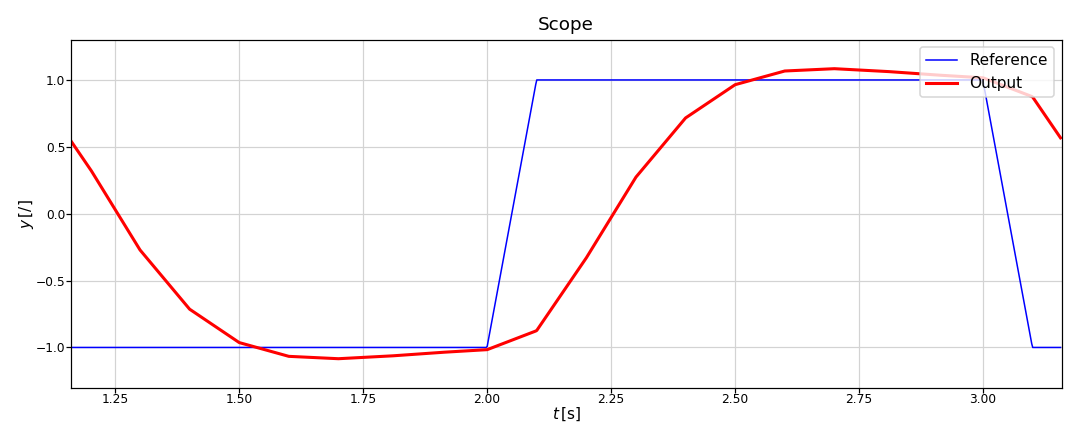

Output()

In [10]:
# Simulation data

anim_fig = plt.figure()
anim_fig.set_size_inches((9.8, 4))
anim_fig.set_tight_layout(True)

anim_ax1 = anim_fig.add_subplot(111)

frame_count=1000
scope_rounds=4

l1 = anim_ax1.plot([], [], lw=1, color='blue')
l2 = anim_ax1.plot([], [], lw=2, color='red')

line1 = l1[0]
line2 = l2[0]

anim_ax1.legend(l1+l2, ['Reference', 'Output'], loc=1)

anim_ax1.set_title('Scope', fontsize=12)
anim_ax1.set_xlabel(r'$t\/$[s]', labelpad=0, fontsize=10)
anim_ax1.set_ylabel(r'$y\/$[/]', labelpad=0, fontsize=10)
anim_ax1.tick_params(axis='both', which='both', pad=0, labelsize=8)

anim_ax1.grid(which='both', axis='both', color='lightgray')

T_plot = []
X_plot = []
R_plot = []

#Simulation function

def simulation(Kp, Ti, Td, Fd, type_select, T1, Tint, T, dt, X, Xf, Xa):
    
    W_sys = c.tf([1], [T1*Tint, Tint, 0])
    
    if type_select in (1, 3, 4):
        Ti0 = 1
    else:
        Ti0 = 0
        
    if type_select in (2, 3, 4):
        Td0 = 1
    else :
        Td0 = 0
        
    if type_select == 4:
        Fd0 = 1
    else:
        Fd0 = 0
    
    # Controller
    P = Kp            # Proportional term
    I = Kp / Ti       # Integral term
    D = Kp * Td       # Derivative term
    Td_f = Td * Fd    # Derivative term filter
    
    W_PID = c.parallel(c.tf([P], [1]),
                       c.tf([I * Ti0], [1 * Ti0, 1 * (not Ti0)]),
                       c.tf([D * Td0, 0], [Td_f * Td0 * Fd0, 1]))    # PID controller
    
    # Model
    W_open = c.series(W_PID, W_sys)         # Open loop
    W_closed = c.feedback(W_open, 1, -1)    # Closed loop with negative feedback
    
    # Reference and disturbance signals

    T_sim = np.arange(0, T, dt, dtype=np.float64)
    
    if X == 0:   # Sine wave reference
        X_sim = np.sin(2 * np.pi * Xf * T_sim) * Xa
    elif X == 1:   # Square wave reference
        X_sim = np.sign(np.sin(2 * np.pi * Xf * T_sim)) * Xa
    
    # System response
        
    Tx, youtx, xoutx = c.forced_response(W_closed, T_sim, X_sim)
    R_sim = youtx
    
    # Display
    
    XR_max = max(np.amax(np.absolute(np.concatenate((X_sim, R_sim)))), Xa)
    
    anim_ax1.set_ylim((-1.2 * XR_max, 1.2 * XR_max))
    
    global T_plot, X_plot, R_plot
    
    T_plot = np.linspace(0, T, frame_count*(scope_rounds+1), dtype=np.float32)
    X_plot = np.interp(T_plot, T_sim, X_sim)
    R_plot = np.interp(T_plot, T_sim, R_sim)
        
def anim_init():
    line1.set_data([], [])
    line2.set_data([], [])
    anim_ax1.set_xlim((0, T_plot[frame_count-1]))
    
    return (line1, line2, anim_ax1,)

def animate(i):
    line1.set_data(T_plot[scope_rounds*i:scope_rounds*i+frame_count-1], X_plot[scope_rounds*i:scope_rounds*i+frame_count-1])
    line2.set_data(T_plot[scope_rounds*i:scope_rounds*i+frame_count-1], R_plot[scope_rounds*i:scope_rounds*i+frame_count-1])
    anim_ax1.set_xlim((T_plot[i*scope_rounds], T_plot[i*scope_rounds+frame_count-1]))
    
    return (line1, line2, anim_ax1,)

anim = animation.FuncAnimation(anim_fig, animate, init_func=anim_init,
                               frames=frame_count, interval=10, blit=True,
                               repeat=True)

# Controllers

T_slider = w.FloatLogSlider(value=10, base=10, min=-0.7, max=1, step=0.01,
                            description='Duration [s]:', continuous_update=False,
                            orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))

dt_slider = w.FloatLogSlider(value=0.1, base=10, min=-3, max=-1, step=0.01,
                             description='Timestep [s]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
       
X_type = w.Dropdown(options=[('Sine', 0), ('Square', 1)], value=1,
                    description='Reference: ', continuous_update=False, layout=w.Layout(width='auto', flex='3 3 auto'))    
Xf_slider = w.FloatLogSlider(value=0.5, base=10, min=-2, max=2, step=0.01,
                             description='Frequency [Hz]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))
Xa_slider = w.FloatLogSlider(value=1, base=10, min=-2, max=2, step=0.01,
                             description='Amplitude [/]:', continuous_update=False,
                             orientation='vertical', layout=w.Layout(width='auto', height='auto', flex='1 1 auto'))    

input_data = w.interactive_output(simulation, {'Kp': Kp_slider, 'Ti': Ti_slider, 'Td': Td_slider,'Fd': Fd_slider,
                                               'type_select': typeSelect, 'T1': T1_slider, 'Tint':Tint_slider,
                                               'T': T_slider, 'dt': dt_slider,
                                               'X': X_type, 'Xf': Xf_slider, 'Xa': Xa_slider})

display(w.HBox([w.HBox([T_slider, dt_slider], layout=w.Layout(width='25%')),
                w.Box([], layout=w.Layout(width='5%')),
                w.VBox([X_type, w.HBox([Xf_slider, Xa_slider])], layout=w.Layout(width='30%')),
                w.Box([], layout=w.Layout(width='5%'))],
                layout=w.Layout(width='100%', justify_content='center')), input_data)


The duration parameter controls the simulated timeframe and does not affect the runtime of the animation. In contrast, the timestep controls the model sampling and can refine the results in exchange for higher computational resources.